# Constraining the Basic Cosmological Parameters of the Universe using the Power Spectrum of Cosmic Microwave Background (CMB)

In [1]:
# Importing necessary Libraries

import time
import camb
import numpy as np
from matplotlib import pyplot as plt

Here we measure the following parameters using data from Planck Satellite

1. Hubble Constant, $H_0$
2. The Density of Regular Baryonic Matter, $ \Omega_b h^2$
3. The Density of Dark Matter, $ \Omega_c h^2$
4. The Amplitude $A_s$ and Tilt $n_s$ of the Initial Power Spectrum of Fluctuation set 
5. Thomson Scattering Optical Depth, $\tau$

The dataset we use here contains Multipoles, Variance of the Sky at the multipoles and the uncertainty of the variance

In [2]:
data = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)

mpl = data[:,0]
mpl_var = data[:,1]
error = 0.5*(data[:,2] + data[:,3])

In [3]:
# Function to Calculate the Power Spectrum from CAMB

pars_name = ['Hubble Constant', 'Baryon Density','Dark Matter Density','Optical Depth','Amplitude of the Spectrum','Tilt of the Spectrum']
def get_spectrum(pars,lmax=3000):
    H0 = pars[0]      # Hubble Constant
    ombh2 = pars[1]   # Baryon Density
    omch2 = pars[2]   # Dark Matter Density
    tau = pars[3]     # Optical Depth
    As = pars[4]      # Amplitude of the Spectrum
    ns = pars[5]      # Tilt of the Spectrum
    pars = camb.CAMBparams()  # Setting up the set of parameters for CAMB
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results = camb.get_results(pars)  # Calculate results for these parameters
    powers = results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb = powers['total']  # One of the CAMB Power Spectra's Dictionary entry containing the total Lensed CMB Power Spectra
    tt = cmb[:,0]    
    model = tt[2:]    # Excluding the 1st two entries, as CAMB returns the power spectrum starting with monopoles
    return model[:len(mpl_var)]   # Since, the shape of the model is (3049,) 

# (a) Analysis of chi-square

chi-Square is  15267.937150261654  for  2501  degrees of freedom.


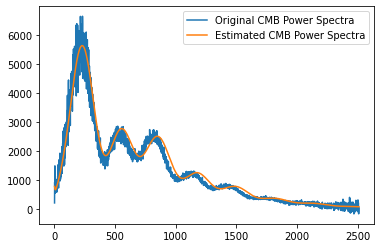

In [4]:
# These are the parameters dialed into the test script

pars_1 = np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
model = get_spectrum(pars_1)
residual = mpl_var - model
chisq = np.sum((residual/error)**2)
print("chi-Square is ",chisq," for ",len(residual)-len(pars_1)," degrees of freedom.")

plt.plot(mpl,mpl_var,label = 'Original CMB Power Spectra')
plt.plot(mpl,model,label = 'Estimated CMB Power Spectra')
plt.legend()
plt.show()

We know that the mean of the chi-square distribution is the number of degrees of freedom, $n$ and the variance is $2n$

The number of degrees of freedom in this case is the diference between the total number of samples and the number of Parameters. Hence, $$ 2507 - 6 = 2501 $$

So, the mean is $2501$ and the variance is $5002$

Since, the chi-square we obtained from the parameters (i.e. $15267.937150261654$) dialed into the test script varies greatly with the mean value (i.e. $2501$), the parameters given are not considered to be an acceptable fit.

chi-Square is  3272.2053559202204  for  2501  degrees of freedom.


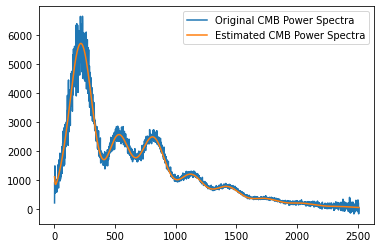

In [5]:
# For the given set of parameters, Let's calculate its power spectra

pars_2 = np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
model = (get_spectrum(pars_2))[:len(mpl_var)]
residual = mpl_var - model
chisq = np.sum((residual/error)**2)
print("chi-Square is ",chisq," for ",len(residual)-len(pars_2)," degrees of freedom.")
plt.plot(mpl,mpl_var,label = 'Original CMB Power Spectra')
plt.plot(mpl,model,label = 'Estimated CMB Power Spectra')
plt.legend()
plt.show()

This new set of parameters can be considered as an acceptable fit as it's chi-square value is closer to its mean. But, still improvement required!

# (b) Newton's Method to determine the Best - Fit Parameters

We use the centered derivative formula to carry out the numerical differentiation

$$ f^{'}  = \frac{f(x + dx) - f(x - dx)}{2*dx} $$

From the derivation of Newton's Method, we arrive the following.

$ m_{n+1} = m_n + (A^{'T} * N^{-1} * A^{'})^{-1} * (A^{'T} * N^{-1} * r) $

where $r$ is the difference between the data and the model (i.e. residual)

$ r = d - A(m) $

The model errors are calculated as

$$  (A^T * N^{-1} * A)^{-1}  $$

In [6]:
def num_derivs(fun,pars,dp,x):    # Calculates the numerical derivatives for each parameter
    A = np.empty([len(x),len(pars)])
    for i in range(len(pars)):
        pp = pars.copy()
        pp[i] = pars[i]+dp[i]
        m_plus = fun(pp)
        pp[i] = pars[i]-dp[i]
        m_minus = fun(pp)
        A[:,i] = (m_plus-m_minus)/(2*dp[i])
    return A

Ninv = np.diag(1/error**2)      # Noise matrix using the errors given in the Planck dataset

def newton(fun,pars,dp,x,y,niter,txtfile=True):
        chiq = []
        for i in range(niter):
            pred = fun(pars)
            A = num_derivs(fun,pars,dp,x)
            residual = y - pred
            chiq.append(np.sum((residual/error)**2))
            
            lhs = A.T@Ninv@A
            rhs = A.T@Ninv@residual
            δp = np.linalg.inv(lhs)@rhs
            pars = pars + δp
            print(f'Parameter Shift for {i} iteration is ',δp)
            
            # To calculate the parameter errors 
            curvature_mat = np.linalg.inv(lhs)
            pars_errors = np.sqrt((np.diag(curvature_mat)))
            
        if txtfile:   # Reporting my best fit paramaters, their errors and curvature matrix to a text file
            with open('planck_fit_params.txt', 'w') as f:
                for i,j,k in zip(pars_name, pars, pars_errors):
                    f.write(f"\n{i} : {j} +/- {k}")   
                f.write(f"\n\n The curvature matrix of the Best-Fit Parameters are \n\n {curvature_mat}")
            f.close()
        return pars,curvature_mat,pars_errors,chiq     # Returning my Best-Fit Parameters 

In [7]:
parameters = np.array([60,0.02,0.11,0.04,2.00e-9,1.0])
dp = np.array([0.1,0.0001,0.001,0.001,1e-10,0.001])

pars,curvature_mat,pars_errors,chiq = newton(get_spectrum,parameters,dp,mpl,mpl_var,10)
print('\nMy Parameters are as follows\n')
for i,j,k in zip(pars_name, pars, pars_errors):
    print(f"{i} : {j} +/- {k}")

Parameter Shift for 0 iteration is  [ 2.21440958e+00  1.21783068e-03  1.60611498e-02  5.58039993e-01
  2.28937544e-09 -4.86986882e-02]
Parameter Shift for 1 iteration is  [ 1.29387944e+01  2.50201824e-03 -2.10014638e-02 -3.68463400e-01
 -1.29873501e-09  3.64515736e-02]
Parameter Shift for 2 iteration is  [-7.42171571e+00 -1.39920988e-03  1.27502474e-02 -1.40270705e-01
 -8.60606963e-10 -2.06045642e-02]
Parameter Shift for 3 iteration is  [ 4.65628776e-01  3.25890620e-05 -3.20302390e-05 -6.41114801e-03
  7.98136808e-11  5.88722798e-03]
Parameter Shift for 4 iteration is  [ 5.30865271e-02  1.15191379e-05 -1.27533507e-04  2.81616349e-03
  1.05957976e-11  5.30062022e-05]
Parameter Shift for 5 iteration is  [-2.33651435e-02 -3.00530989e-06  5.14399330e-05 -9.72651856e-04
 -4.00086931e-12 -1.20718246e-04]
Parameter Shift for 6 iteration is  [ 4.27516647e-03  5.25319905e-07 -9.65760624e-06  2.29004577e-04
  9.60147742e-13  2.31978601e-05]
Parameter Shift for 7 iteration is  [-4.73341841e-04 -5

# (c) MCMC

In [8]:
# Let's define a step size generator from the curvature matrix

def get_step(npars,cov,scale):
    return scale * np.random.multivariate_normal(np.zeros(npars),cov)

# Defining a function to calculate the model using the parameters and finding the chi-square of the model
def calc_chisq(fun,pars,data,sigma):
    model = fun(pars)
    residual = data - model
    chisq = np.sum((residual/sigma)**2)
    return model,chisq

def mcmc_chain(fun,pars,cov,data,sigma,nstep,step_scale):
    with open('planck_chain.txt', 'w') as f:
        npar = len(pars)
        chain = np.zeros([nstep,npar])  # To store the values of parameters
        chisq = np.zeros(nstep)         # To store the values of chi-square
        chain[0,:] = pars
        model,chi_square = calc_chisq(fun,pars,data,sigma)
        chisq[0] = chi_square
        f.write(f'{str(chisq[0])}\t')
        f.write(f'{str(pars)}\n')
        f.write(f'\n')

        accepted = 0   # We do this to counts the acceptance fraction (Refered from Assignment 4 Solution set)
        for i in range(1,nstep):
            pp = pars + get_step(npar,cov,step_scale)
            model,new_chisq = calc_chisq(fun,pp,data,sigma)
            accept_prob = np.exp(-0.5*(new_chisq-chi_square))
            if np.random.rand(1)<accept_prob:    # If the probability is greater than 1, accept the new parameters, as our chi-square improved!
                accepted += 1                    # Increment the Acceptance counter
                pars = pp                        # Assign the new parameters
                chi_square = new_chisq    
            chain[i,:]=pars       # Update the paramters
            chisq[i]=chi_square   # Update the chi-square list
            f.write(f'{str(chisq[i])}\t')
            f.write(f'{str(pars)}\n')
            f.write(f'\n')
        print(f"Accepted {accepted} steps of {nstep} -> Acceptance Ratio: {accepted/nstep}")
        return chain,chisq

In [9]:
pars = np.array([75,0.02,0.11,0.05,2.00e-9,0.98])
chain,chisq = mcmc_chain(get_spectrum, pars, curvature_mat, mpl_var, error, 5000,0.5 )

print('My Best-Fit Parameters from MCMC are as follows\n')
means = np.mean(chain,axis=0)
errors = np.std(chain,axis=0)
for i,j,k in zip(pars_name, means,errors):
    print(f"{i} : {j} +/- {k}")

Accepted 2458 steps of 5000 -> Acceptance Ratio: 0.4916
My Best-Fit Parameters from MCMC are as follows

Hubble Constant : 69.6317326492113 +/- 4.628843923513785
Baryon Density : 0.02240888699466869 +/- 0.00039444398775898237
Dark Matter Density : 0.11511200018186019 +/- 0.008924515649480247
Optical Depth : 0.09073341897882208 +/- 0.02834222898702969
Amplitude of the Spectrum : 2.231085646382736e-09 +/- 1.0729454733194721e-10
Tilt of the Spectrum : 0.9789642425986743 +/- 0.020333498934682816


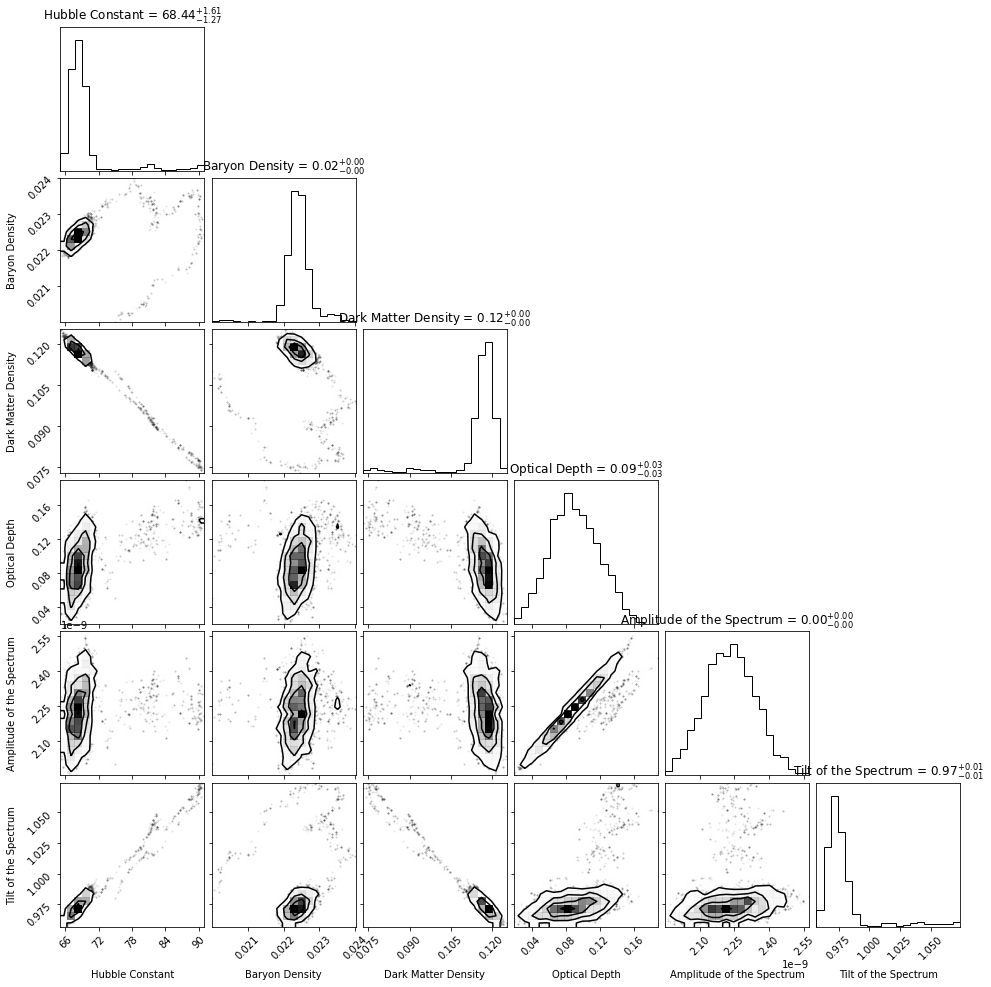

In [10]:
# Let's use corner Plots to analyse our chain

from corner import corner
corner(chain,labels=pars_name,show_titles=True);

We can see that each parameter has a gaussian like distribution, which means that they have converged, Let's look at the deviation of each paramter during the iterations

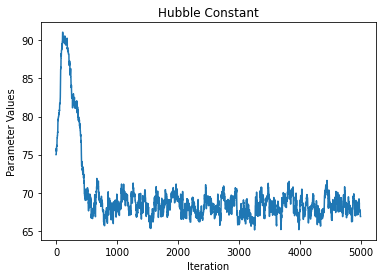

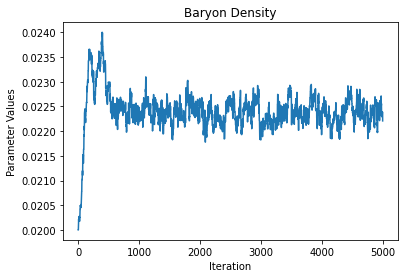

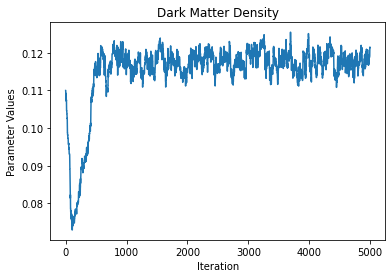

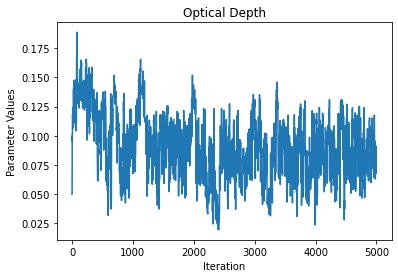

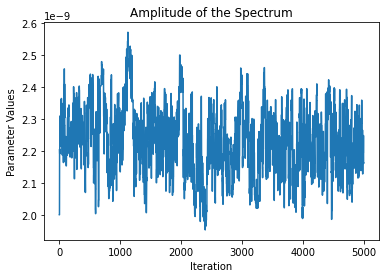

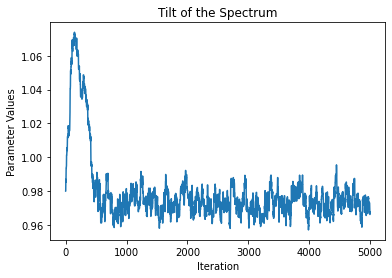

In [27]:
for i,j in zip(range(len(pars)),pars_name):
    plt.figure()
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Values')
    plt.title(j)
    plt.plot(chain[:,i])

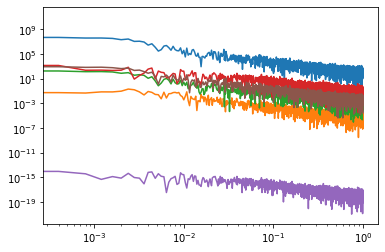

In [28]:
# Let's see the FFT Plots

plt.figure()
for i in range(6):
    psd = np.abs(np.fft.rfft(chain[:,i]))**2
    plt.loglog(np.linspace(0,1,len(psd)),psd)

Looking at the deviation and FFT plots, we can see that the data looks very much like white noise, especially, the flat power spectral density on the left portion of x axis on the FFT plot. From these inferences I conclude that my chain has converged.

To find the mean value of Dark Energy $\Omega_\Lambda$, 

Assuming the universe is spatially flat, we know

$$ \Omega_\Lambda + \Omega_b + \Omega_c = 1 $$

From our model's parameter $\Omega_b h^2$ and $\Omega_c h^2$ we can calculate the value of $\Omega_b$ and $\Omega_c$, knowing $ h = H_0 / 100$

Hence, $$ \Omega_\Lambda = 1 - (\Omega_b + \Omega_c) $$

In [34]:
omb = []   # Density parameter for Baryonic Matter
omc = []   # Density parameter for Dark Matter

h = chain[:,0] / 100
omb.append(chain[:,1]/(h**2))
omc.append(chain[:,2]/(h**2))

omd = 1 - (omc[0]+omb[0])   # Density parameter for Dark Energy

print(f'The mean value of density parameter for Baryonic Matter is',np.mean(omb) ,'+/-', np.std(omb))
print(f'The mean value of density parameter for Dark Matter is',np.mean(omc) ,'+/-', np.std(omc))
print(f'The mean value of density parameter for Dark Energy is',np.mean(omd) ,'+/-', np.std(omd))

The mean value of density parameter for Baryonic Matter is 0.04667717799567516 +/- 0.004615172917623614
The mean value of density parameter for dark matter is 0.2418074807179407 +/- 0.03789601744134398
The mean value of density parameter for dark energy is 0.7115153412863842 +/- 0.042460890243018704


Hence, the mean value of Dark Energy has been calculated to be $0.7115153412863842 +/- 0.042460890243018704$

# (d) Constraint on Reionisation with $\tau = 0.0540 +/- 0.0074$ 

We have the mean of $\tau = 0.0540$ and the error of  $\tau = 0.0074$

We compare the likelihood ratio of $\tau$ at each iteration and add it to the current iteration's chi-square

In [226]:
# Let's define a function that calculate the likelihood ratio of chi-squares for 'tau'

def δ_chi_tau(tau):
    tau_mean = 0.0540
    tau_error = 0.0074
    return ((tau- tau_mean) / tau_error)**2
    

def mcmc_chain_tauprior(fun,pars,cov,data,sigma,nstep,step_scale):
    with open('planck_chain_tauprior.txt', 'w') as f:
        npar = len(pars)
        chain = np.zeros([nstep,npar])  # To store the values of parameters
        chisq = np.zeros(nstep)         # To store the values of chi-square
        chain[0,:] = pars
        model,chi_square = calc_chisq(fun,pars,data,sigma)
        
        # Enforcing the constraint on 'tau' by adding the ratio of tau likelihoods to the current chi-square
        chi_square = chi_square + δ_chi_tau(pars[3])
            
        chisq[0] = chi_square
        f.write(f'{str(chisq[0])}\t')
        f.write(f'{str(pars)}\n')
        f.write(f'\n')
      
        
        accepted = 0   # We do this to counts the acceptance fraction (Refered from Assignment 4 Solution set)
        for i in range(1,nstep):
            pp = pars + get_step(npar,cov,step_scale)
            model,new_chisq = calc_chisq(fun,pp,data,sigma)
            
            # Enforcing the constraint on 'tau' by adding the ratio of tau likelihoods to the current chi-square
            new_chisq = new_chisq + δ_chi_tau(pp[3])
            
            accept_prob = np.exp(-0.5*(new_chisq-chi_square))
            if np.random.rand(1)<accept_prob:    # If the probability is greater than 1, accept the new parameters, as our chi-square improved!
                accepted += 1                    # Increment the Acceptance counter
                pars = pp                        # Assign the new parameters
                chi_square = new_chisq    
            chain[i,:]=pars       # Update the paramters
            chisq[i]=chi_square   # Update the chi-square list
            f.write(f'{str(chisq[i])}\t')
            f.write(f'{str(pars)}\n')
            f.write(f'\n')
        print(f"Accepted {accepted} steps of {nstep} -> Acceptance Ratio: {accepted/nstep}")
        return chain,chisq

In [228]:
pars = np.array([75,0.02,0.11,0.05,2.00e-9,0.98])
tau_chain,tau_chisq = mcmc_chain_tauprior(get_spectrum, pars, curvature_mat, mpl_var, error, 5000,0.5 )

print(f"My Best-Fit Parameters from MCMC with constraints on tau are as follows\n")
means = np.mean(tau_chain,axis=0)
errors = np.std(tau_chain,axis=0)
for i,j,k in zip(pars_name, means,errors):
    print(f"{i} : {j} +/- {k}")

Accepted 1480 steps of 5000 -> Acceptance Ratio: 0.296
My Best-Fit Parameters from MCMC with constraints on tau are as follows

Hubble Constant : 69.39053545079985 +/- 5.177619713975608
Baryon Density : 0.02229747686823154 +/- 0.000441653352249401
Dark Matter Density : 0.1156386240469539 +/- 0.009816830884491335
Optical Depth : 0.05982122493332847 +/- 0.015057867234307755
Amplitude of the Spectrum : 2.097312746423483e-09 +/- 4.144332771857529e-11
Tilt of the Spectrum : 0.9779908955352498 +/- 0.02380754766884338


We see that we got the $\tau$ alue to be $0.05982122493332847$ which is closer to the mean value and better than the value we got (i.e. $0.09073341897882208 $) from running the chain without the constraint. 

Now, let's do importance sampling on our chain from part (c). We do this by performing weighted average on each value of the $\tau$ parameter. The weight here is likelihood ratio of the estimated tau and the mean tau. This is given by,

$$ e^{-\frac{1}{2} * \Delta \chi^2}$$

where $\Delta \chi^2$ is the given by,

$$ \frac {(\tau_i - \tau_{mean})^2}{(\tau_{error})^2}$$

In [222]:
# Importance Sampling of 'tau'

tau = chain[:,3]   # This is our 'tau' values from the chain
w = np.exp(-0.5 * δ_chi_tau(tau) )  # Defining our weights

𝜏 = np.average(tau,weights=w)
print(f'The value of 𝜏 after performing importance sampling is {𝜏}')

The value of 𝜏 after performing importance sampling is 0.05652643197093271


The value of $\tau$ obtained from enforcing the constraint, $0.05982122493332847$ agrees well with the $\tau$ value obtained from importance sampling, $0.05652643197093271$

In [236]:
# Let's do importance sampling on all the parameters

hubble = chain[:,0]
ombh = chain[:,1]
omch = chain[:,2]
tau = chain[:,3]
amplitude = chain[:,4]
tilt = chain[:,5]

for i,j in zip(range(6),pars_name):
    print(f'The value of {j} after performing importance sampling is {np.average(chain[:,i],weights=w)}')

The value of Hubble Constant after performing importance sampling is 67.86743901543602
The value of Baryon Density after performing importance sampling is 0.022310854699618406
The value of Dark Matter Density after performing importance sampling is 0.11857479853363458
The value of Optical Depth after performing importance sampling is 0.05652643197093271
The value of Amplitude of the Spectrum after performing importance sampling is 2.09923683808543e-09
The value of Tilt of the Spectrum after performing importance sampling is 0.9711275997452741


In [252]:
# Comparing the parameters from constrained MCMC and importance sampling...

print(f'\tParameter\t\t Constrained MCMC\t\t\tImportance Sampling')
print('-----------------------------------------------------------------------------------------------------')
for i,j,z in zip(pars_name,means,range(6)):
    print(f'{i}\t\t\t{j}\t\t\t{np.average(chain[:,z],weights=w)}')

	Parameter		 Constrained MCMC			Importance Sampling
-----------------------------------------------------------------------------------------------------
Hubble Constant			69.39053545079985			67.86743901543602
Baryon Density			0.02229747686823154			0.022310854699618406
Dark Matter Density			0.1156386240469539			0.11857479853363458
Optical Depth			0.05982122493332847			0.05652643197093271
Amplitude of the Spectrum			2.097312746423483e-09			2.09923683808543e-09
Tilt of the Spectrum			0.9779908955352498			0.9711275997452741
